# __Name__

Description & tasks

In [52]:
import itertools
import math 
from pathlib import Path
import os
import random
import shutil
import sys
from typing import Optional, Union

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import losses
from keras import metrics
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split


In [17]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'


set_seed(1)

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

In [ ]:
# hyperparameters
cfg = {
       'image_size': 32,
       'batch_size': 256,
       }

##### Loading `from files:` (csv)

In [18]:
def read_from_csvfile(file: Union[Path, str], header: Optional[str]='infer') -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file, header=header)
    
    return df


data = read_from_csvfile(f'{os.getcwd()}/data/data.csv')
# print(data.head(3), data.tail(3))

In [19]:
y = data['0'].to_numpy()
# за замовчуванням axis=0, що означає роботу з рядками. Якщо вказати axis=1, то це дозволить видаляти стовпці:
data.drop(['0'], inplace=True, axis=1) 
data

,1,2,3,4,5,6,7,8,9,10,...,67491,67492,67493,67494,67495,67496,67497,67498,67499,67500
0,0.952941,0.949020,0.831373,0.964706,0.960784,0.850980,0.956863,0.949020,0.850980,0.960784,...,0.396078,0.800000,0.666667,0.388235,0.788235,0.654902,0.376471,0.772549,0.639216,0.360784
1,0.352941,0.321569,0.313725,0.352941,0.321569,0.313725,0.356863,0.325490,0.317647,0.356863,...,0.203922,0.152941,0.184314,0.196078,0.113725,0.145098,0.156863,0.164706,0.196078,0.207843
2,0.882353,0.850980,0.807843,0.886275,0.854902,0.811765,0.909804,0.870588,0.835294,0.917647,...,0.403922,0.207843,0.313725,0.396078,0.231373,0.333333,0.423529,0.223529,0.317647,0.419608


##### Loading `from prepared 'RAW-files'`: (into `ImageDataGenerator`)

In [4]:
# kaggle competitions download -c dogs-vs-cats

- https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.joinpath
- https://docs.python.org/uk/3/library/shutil.html

In [20]:
train_size = 1000  # % of num-files...
validation_size = 500  # next 500 for 1000
test_size = 500  # next 500 for 500
src, dst = '/media/denys/ftb/sprojects/trainCatsDogs/train/', f'{os.getcwd()}/data/'


def create_dataset_directories(base_dir: str, categories: set) -> None:
    print('Start creation of dataset directories...')

    Path(base_dir).mkdir(parents=True, exist_ok=True)

    directories = ['train', 'validation', 'test']
    for directory in directories:
        sub_dir = Path(base_dir).joinpath(directory)
        Path(sub_dir).mkdir(parents=True, exist_ok=True)
        [Path(sub_dir.joinpath(c)).mkdir(parents=True, exist_ok=True) for c in categories]

    print('Done preparing directories.')


def copy_data(
              src: str, 
              dst: str, 
              example_name: str, 
              ext: str,
              start: int, 
              end: int
              ) -> None:
    fnames = [f'{example_name}.{i}.{ext}' for i in range(start, end)]
    print(f'Copying... into {dst}...')
    for fname in fnames:
        # print(f'Copying {fname} to {dst}')
        shutil.copyfile(
                        Path(src).joinpath(fname),
                        Path(dst).joinpath(fname)
                        )


def identify_categories(src_dir: str) -> set:
    all_files = [el.stem.split('.')[0] for el in Path(src_dir).iterdir() if el.is_file()]

    return set(all_files)


if Path(src).is_file() or Path(dst).is_file():
    print('Incorrect paths, there must be a folders.')

else:
    # images in src - all in one where filenames start with label (category)
    categories: set = identify_categories(src)
    create_dataset_directories(dst, categories)

    # if same extensions of images:
    ext: str = {0:el.suffix[1:] for el in Path(src).iterdir() if el.is_file()}.get(0, '')

    for category in categories:   # ! // \\ linux windows
        copy_data(src, f'{dst}/train/{category}/', category, ext, 0, train_size)
        copy_data(src, f'{dst}/validation/{category}/', category, ext, train_size, train_size + validation_size)
        copy_data(src, f'{dst}/test/{category}/', category, ext, train_size + validation_size, train_size + validation_size + test_size)


Start creation of dataset directories...
Done preparing directories.
Copying... into /media/denys/ftb/sprojects/datas/helps/data//train/cat/...
Copying... into /media/denys/ftb/sprojects/datas/helps/data//validation/cat/...
Copying... into /media/denys/ftb/sprojects/datas/helps/data//test/cat/...
Copying... into /media/denys/ftb/sprojects/datas/helps/data//train/dog/...
Copying... into /media/denys/ftb/sprojects/datas/helps/data//validation/dog/...
Copying... into /media/denys/ftb/sprojects/datas/helps/data//test/dog/...


###### __ImageDataGenerator__

- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [10]:
# from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

target_size = (150, 150)  # for conver to size
batch_size = 20
# one of 'binary', 'categorical', 'input', 'multi_output', 'raw', 'sparse' or None. Default: 'categorical':
class_mode = 'binary' if len(categories) == 2 else 'categorical'

train_dir = '/media/denys/ftb/sprojects/datas/helps/data/train/'
validation_dir = '/media/denys/ftb/sprojects/datas/helps/data/validation/'
test_dir = '/media/denys/ftb/sprojects/datas/helps/data/test/'

train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode=class_mode
                                                    )

validation_generator = validation_datagen.flow_from_directory(
                                                        validation_dir,
                                                        target_size=target_size,
                                                        batch_size=batch_size,  # 1 !
                                                        class_mode=class_mode
                                                        )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=target_size,
                                                  batch_size=1,
                                                  class_mode=class_mode
                                                  )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_generator, validation_generator, test_generator

(<keras.src.preprocessing.image.DirectoryIterator at 0x7f63706abc10>,
 <keras.src.preprocessing.image.DirectoryIterator at 0x7f6370766290>)

###### save to file

In [25]:
generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                                   train_dir,
                                                                   target_size=target_size,
                                                                   batch_size=1,
                                                                   class_mode=class_mode
                                                                   )

Found 2000 images belonging to 2 classes.


- https://pandas.pydata.org/docs/user_guide/merging.html

In [51]:
data_df = pd.DataFrame()
for i, (images, y_batch) in enumerate(generator):
    new_line = pd.DataFrame([[y_batch] + [images[0][a][b][c] for a in range(images[0].shape[0]) for b in range(images[0].shape[1]) for c in range(images[0].shape[2])]], index=[i])
    data_df = pd.concat([data_df, new_line])
    if i == 2:
        break
       
data_df 

[0.]
[0.]
[1.]


,0,1,2,3,4,5,6,7,8,9,...,67491,67492,67493,67494,67495,67496,67497,67498,67499,67500
0,[0.0],0.784314,0.784314,0.737255,0.784314,0.776471,0.729412,0.780392,0.764706,0.721569,...,0.031373,0.027451,0.035294,0.031373,0.027451,0.035294,0.031373,0.027451,0.035294,0.031373
1,[0.0],0.384314,0.372549,0.305882,0.368627,0.356863,0.290196,0.333333,0.321569,0.254902,...,0.807843,0.823529,0.823529,0.815686,0.890196,0.882353,0.894118,0.945098,0.937255,0.949020
2,[1.0],0.858824,0.843137,0.847059,0.870588,0.847059,0.854902,0.870588,0.847059,0.847059,...,0.407843,0.482353,0.490196,0.403922,0.482353,0.490196,0.403922,0.478431,0.486275,0.400000


In [47]:
data_df.to_csv('/media/denys/ftb/sprojects/datas/helps/data/data.csv', index=False)

##### Loading by Dataset `from 'RAW-files':` (class Dataset)

In [64]:
PATH_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'train')

ids = []  # full image paths
labels = []  # true mark 'images name-description' by label2index:
# label2index = {kind:num for num, kind in enumerate(os.listdir(PATH_IMGS))}
label2index = {}

for num, folder in enumerate(os.listdir(PATH_IMGS)):
    label2index[folder] = num
    for image_name in os.listdir(os.path.join(PATH_IMGS, folder))[:500]:  # limit 500 for each - for example
        ids.append(os.path.join(PATH_IMGS, folder, image_name))
        labels.append(label2index[folder])

NUM_CLASSES = num + 1
NUM_CLASSES

10

In [21]:
index2label = {y: x for x, y in label2index.items()}
index2label

{0: 'dog',
 1: 'ship',
 2: 'frog',
 3: 'automobile',
 4: 'bird',
 5: 'deer',
 6: 'truck',
 7: 'cat',
 8: 'airplane',
 9: 'horse'}

In [28]:
ids_train, ids_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, shuffle=True)  # these are all lists

- https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
- https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

- https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html
- https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/

- https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0
- https://stackoverflow.com/questions/64276472/valueerror-the-input-must-have-3-channels-got-input-shape-200-200-1

- https://albumentations.ai/docs/
- https://albumentations.ai/docs/getting_started/image_augmentation/

In [59]:
# import albumentations as A

train_transforms = A.Compose(
                             [
                              A.HorizontalFlip(p=0.5),
                              A.Rotate(limit=90, p=1.),
                              A.Blur(p=0.25),
                              A.Resize(cfg['image_size'], cfg['image_size'], p=1.),
                             ]
                              )

valid_transforms = A.Compose(
                             [
                              A.Resize(cfg['image_size'], cfg['image_size'], p=1.),
                             ]
                              )

RGB:

In [66]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, ids: list, y: list, num_classes: int, shuffle: bool=True, batch_size: int=256, to_size: int=32, transforms: Optional[A.Compose]=None) -> None:
        self.ids = ids  # list of imgs path
        self.y = y  # list of int, each value = category class
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.ids))
        self.batch_size = batch_size
        self.num_features = to_size * to_size  # self.num_features if self.__getitem__(0) else to_size * to_size
        self.num_classes = num_classes
        self.to_size = to_size
        self.transforms = transforms
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self) -> int:
        return len(self.ids) // self.batch_size
    
    def __getitem__(self, idx: int) -> tuple:  # get one batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_ids = [self.ids[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], num_classes=self.num_classes) for i in indexes]
        
        batch_X = []
        for i in range(self.batch_size):
            img = cv2.imread(batch_ids[i])  # i/o disk operation! but low RAM uses. (img.shape = (32, 32, 3))
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # ! if picture in BGR ?
            img = cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if len(img.shape)==2 else img  # grayscale to RGB
            if self.transforms:
                img = self.transforms(image=img)['image']
            # batch_X.append(img.reshape(self.num_features))  # into a one-dimensional vector
            batch_X.append(img)
            # img = np.mean(img, axis=-1)  # RGB to grayscale: 32*32*3 to 32*32
            # batch_X.append(img.reshape(len(img[0]) * len(img)))  # into a one-dimensional vector
        
        # self.num_features = self.to_size, self.to_size  # len(img[0]) * len(img) # !!
        
        return np.array(batch_X) / 255., np.array(batch_y)
        
    def on_epoch_end(self) -> None:
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [70]:
train_dataset = Dataset(ids_train, y_train, NUM_CLASSES, shuffle=True, batch_size=cfg['batch_size'], to_size=cfg['image_size'], transforms=None)
# train_dataset[0]
NUM_FEATURES = train_dataset.num_features
valid_dataset = Dataset(ids_valid, y_valid, NUM_CLASSES, shuffle=False, batch_size=cfg['batch_size'], to_size=cfg['image_size'], transforms=None)
NUM_FEATURES

1024

In [71]:
train_dataset = Dataset(ids_train, y_train, NUM_CLASSES, shuffle=False, batch_size=1, transforms=train_transforms)

X, y = train_dataset[0]
X.shape, y.shape

((1, 224, 224, 3), (1, 10))

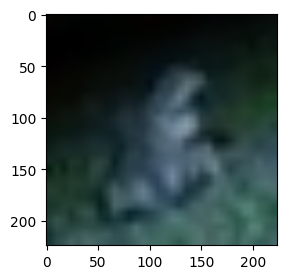

In [86]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[0][0][0])

array data (grayscale) to RGB:

In [88]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, X: np.array, y: np.array, shuffle=True, batch_size=256, to_size=32, transforms: Optional[A.Compose]=None) -> None:
        self.X = X  # (60000, 28, 28)  #! gray
        self.y = y  # (60000, 10)
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        self.batch_size = batch_size
        self.num_features = to_size * to_size
        self.to_size = to_size
        self.transforms = transforms
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self) -> int:
        return math.ceil(self.y.shape[0] / self.batch_size)
    
    def __getitem__(self, idx)-> tuple:  # idx = batche's numder
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]

        batch_X_row = [self.X[i] for i in indexes]
        batch_y = [self.y[i] for i in indexes]

        if self.transforms:
            batch_X = [self.transforms(image=cv2.resize(img, (self.to_size, self.to_size)))['image'] for img in batch_X_row]
        
        else:
            batch_X = [cv2.cvtColor(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB) for img in batch_X_row]

        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self) -> None:
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [ ]:
# train_dataset = Dataset(ids_train, y_train, NUM_CLASSES, shuffle=True, batch_size=cfg['batch_size'], to_size=cfg['image_size'], transforms=train_transforms)
# valid_dataset = Dataset(ids_valid, y_valid, NUM_CLASSES, shuffle=False, batch_size=cfg['batch_size'], to_size=cfg['image_size'], transforms=valid_transforms)

__PYTORCH__:

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import albumentations as A
from albumentations import pytorch as A_torch
from tqdm import tqdm

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms):
        self.names = df["image_id"].values
        self.targets = df["label"].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, index):
        image_name = self.names[index]
        image = cv2.imread(f"/kaggle/input/cassava-leaf-disease-classification/train_images/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (cfg["image_size"], cfg["image_size"]))
        
        image = self.transforms(image=image)["image"]
        
        y = torch.tensor(self.targets[index], dtype=torch.long)
        
        return image, y

### __`MODEL`__

- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [ ]:
callback_early_stopping = EarlyStopping(
                                        monitor='val_categorical_accuracy',  # val_loss
                                        patience=4,
                                        )

callback_save = ModelCheckpoint(
                                'best.hdf5',  # name to save the resulting model
                                monitor='val_loss',
                                save_best_only=True,
                                )

#### __`Training`__

In [ ]:
history = model.fit(
                    train_dataset,
                    validation_data=valid_dataset,
                    epochs=20,
                    verbose=1, # print logs
                    callbacks=[callback_early_stopping, callback_save]  # callback_save
                    )

In [ ]:
history = model.fit(
                    train_datagen,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=valid_datagen,
                    validation_steps=100
                    )

- https://stackoverflow.com/questions/62836066/infinite-loop-with-imagedatagenerator

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50
                    )

### __`INTERPRET`__ / __`Error Analysis`__

### __`RE-TEST`__

### __`RESULTS` & `CONCLUSIONS`__